# Install ASE

with modifications for symmetrized surfaces

In [1]:
import subprocess
import sys
try:
    sys.path.insert(0,'/data/git/ase/')
except FileNotFoundError as E:
    pass
try:
    import ase
except ModuleNotFoundError as E:
    subprocess.check_call([sys.executable, '-m','pip','install','git+https://gitlab.com/mdforti/ase.git'])
    import ase

# Load Machinery for google drive


In [2]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except Exception as E:
    pass
    
if os.path.exists('/content/drive'):
  pathtofiles='/content/drive/Shareddrives/Tenacidad_Zr-ZrO2/'
else:
  pathtofiles=os.getcwd()
if pathtofiles is not os.getcwd():
  os.chdir(pathtofiles)

# load ASE 

In [3]:
from ase.io.vasp import read_vasp
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.build import surface, make_supercell
from ase.build.surfaces_with_termination import surfaces_with_termination, atom_index_in_top, atom_index_in_bottom
from ase.geometry import get_layers
from ase.build import bulk, hcp10m10, hcp0001
from ase.build import stack
from ase.io import write
from ase.io.vasp import write_vasp
from importlib.machinery import  SourceFileLoader
from ase import Atoms
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(25,10))
import numpy as np
from ase.build.surfaces_with_termination import (atom_index_in_bottom, atom_index_in_top)

In [4]:
zro2 = read_vasp('Structure/POSCAR')

In [5]:
def plotviews(atoms_object,
              rotation1='-90x',
              rotation2='-90x, 45y',
              rotation3='0x'):
  fig = plt.figure()
  ax1 = fig.add_axes((0.1,0.1, 0.3,0.8))
  ax2 = fig.add_axes((0.3,0.1, 0.3,0.8))
  ax3 = fig.add_axes((0.6,0.1, 0.3,0.8))
  plot_atoms(atoms_object,rotation=rotation1, ax=ax1)
  plot_atoms(atoms_object,rotation=rotation2, ax=ax2)
  plot_atoms(atoms_object,rotation=rotation3,ax=ax3)
  return ax1, ax2, ax3

In [6]:
def remove_bottom_atom(theatoms):
    atoms = theatoms.copy()
    layers, hs = get_layers(atoms,(0,0,1))
    atoms_in_bottom = atom_index_in_bottom(layers)
    atoms.pop(atoms_in_bottom[-1])
    return atoms

# Objetivo

lo primero que quiero hacer es reconstruir la interfaz de paula:

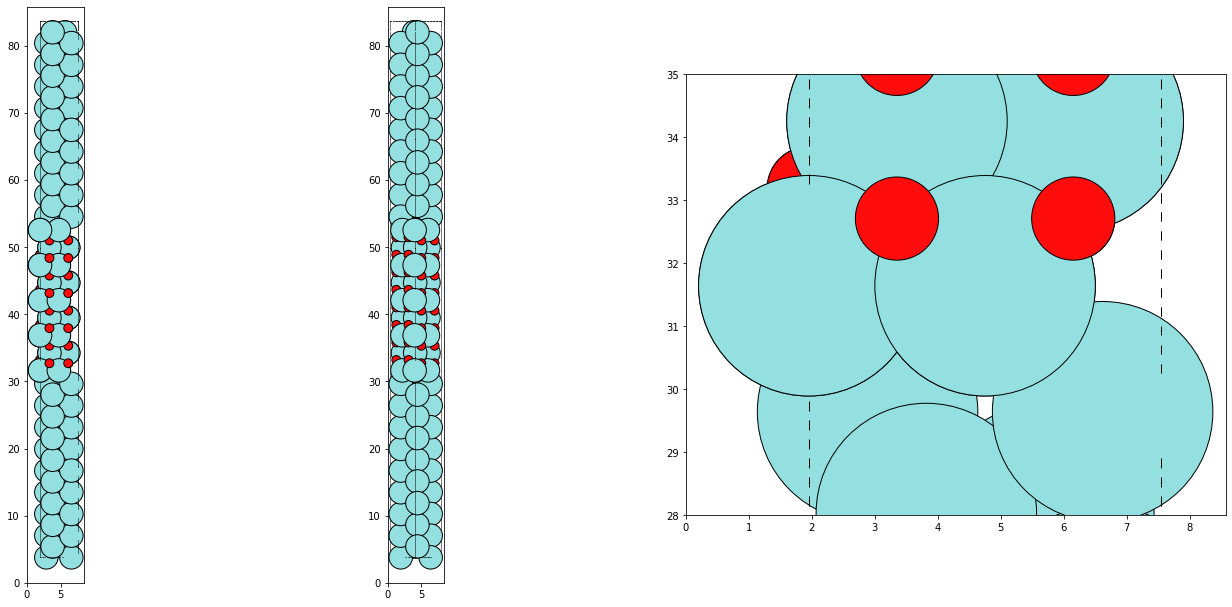

In [7]:
intf=read_vasp('Interfaces/POSCAR_primero.vasp')

ax1, ax2, ax3 = plotviews(intf, rotation3='-90x')
ax3.set_ylim([28,35])
fig = plt.gcf()

- observamos que con esos parámetros de red la ZrO<sub>2</sub> está muy comprimida (casi el 30%, hay dos celdas en el slab de óxido)
- observamos que la terminación de la zr debe ser O(valle) , mientras que la que está ahí calculada es Zr.
- a demás hay demasiados átomos!

respecto de esa última observación, tomamos en VESTA la siguiente estructura:

In [8]:
intf_red = read_vasp('Interfaces/POSCAR_reducido.vasp')

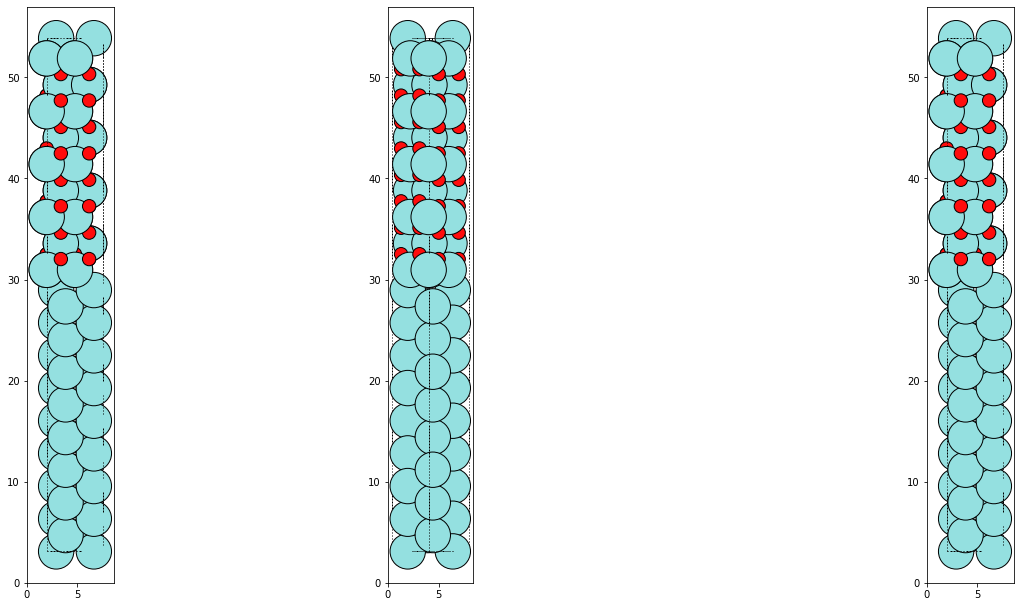

In [9]:
ax1, ax2, ax3 = plotviews(intf_red, rotation3='-90x')

# Superficies

In [10]:
get_adsite = SourceFileLoader(
    'makeadsite',
    'Tools.py').load_module().get_adsite
make_adstruc = SourceFileLoader(
    'makeadsite',
    'Tools.py').load_module().make_adstruc

## ZrO2

tratamos de hacer las superficie que a paula le dió mas estable

primero genero la superficie de ZrO<sub>2</sub>

para tener la superficie mas estable y simétrica, hay que sacar algunos átmos:
- los oxígenos de la ceresta
- los zr de la tapa de abajo

# Superficies con terminacion con ASE

In [11]:
ZrO2001Oterm = surfaces_with_termination(zro2, [0,0,1],layers=4, vacuum=15., termination='O',verbose=True, symmetric=True)
[write_vasp(f'ZrO2001_1x1_{i}.vasp', thisone, sort=True, direct=True) for i, thisone in enumerate(ZrO2001Oterm)]

([4], ['Zr']) ([20], ['O'])
([3], ['O']) ([18], ['O'])
([5], ['Zr']) ([21], ['O'])
([2], ['O']) ([19], ['O'])


[None, None, None, None]

In [12]:
ZrO2001Zrterm = surfaces_with_termination(zro2, [0,0,1], 5, vacuum=10., termination='Zr',symmetric=True)

([0], ['O']) ([28], ['Zr'])
([1], ['O']) ([29], ['Zr'])


In [13]:
ZrO2001Zrterm_2x2 = [make_supercell(ZrO2001Zrterm[i],[[2,0,0],[0,2,0],[0,0,1]],tol=1e-10, wrap=True) for i in range(len(ZrO2001Zrterm))]
translate = [this.translate([this[0].x]) for this in ZrO2001Zrterm_2x2]
write_the_cells = [this.write(f'ZrO2001_2x2_{i}.vasp',sort=True, direct=True, format='vasp') for i,this in enumerate(ZrO2001Zrterm_2x2)]

la que corresponde con el modelo de Paula es la última, pero para que quede igual hay que hacerle una trasación todavía:

[(<Axes:>, <Axes:>, <Axes:>), (<Axes:>, <Axes:>, <Axes:>)]

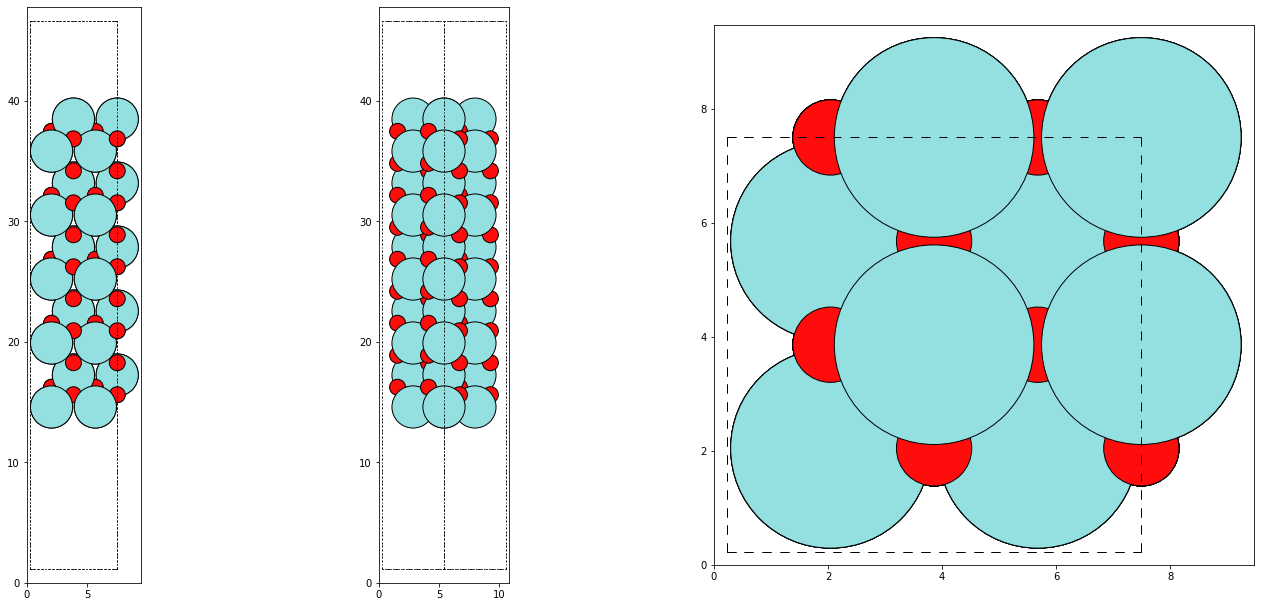

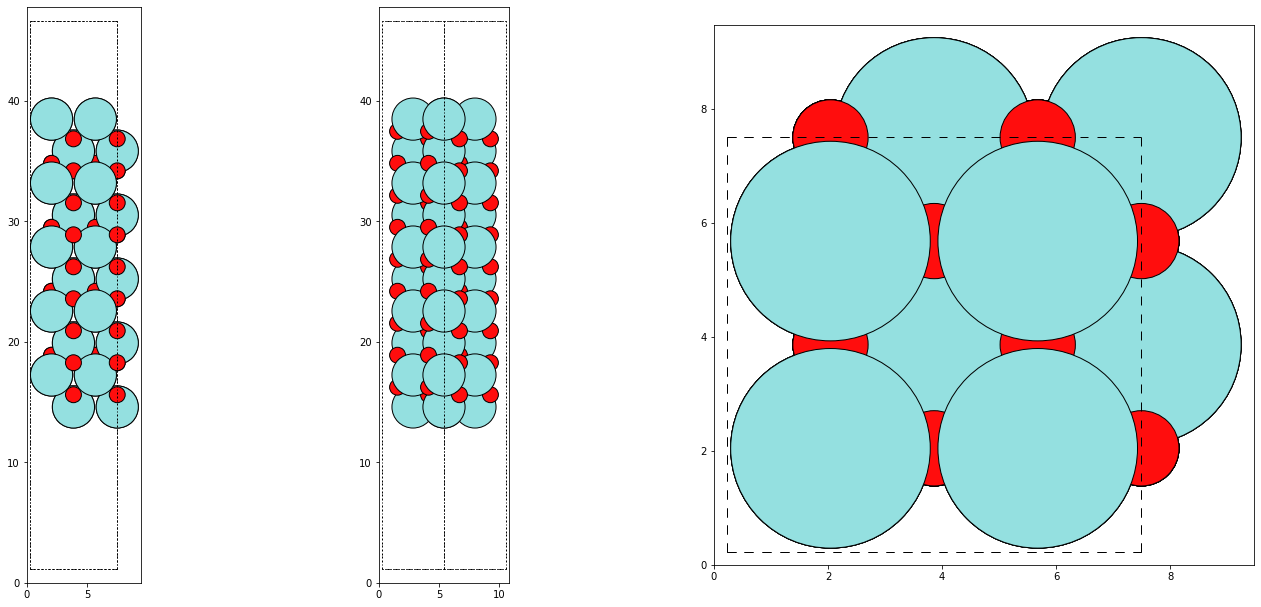

In [14]:
[ plotviews(this) for this in ZrO2001Zrterm_2x2]

In [15]:
get_adsite = SourceFileLoader(
    'makeadsite',
    'Tools.py').load_module().get_adsite

thesites  = [get_adsite(theintf,site='bridge', face='top') for theintf in ZrO2001Zrterm_2x2]
thesites  = [get_adsite(theintf,site='top', face='top') for theintf in ZrO2001Zrterm_2x2]
thesites  = [get_adsite(theintf,site='hollow', face='top') for theintf in ZrO2001Zrterm_2x2]

(<Axes:>, <Axes:>, <Axes:>)

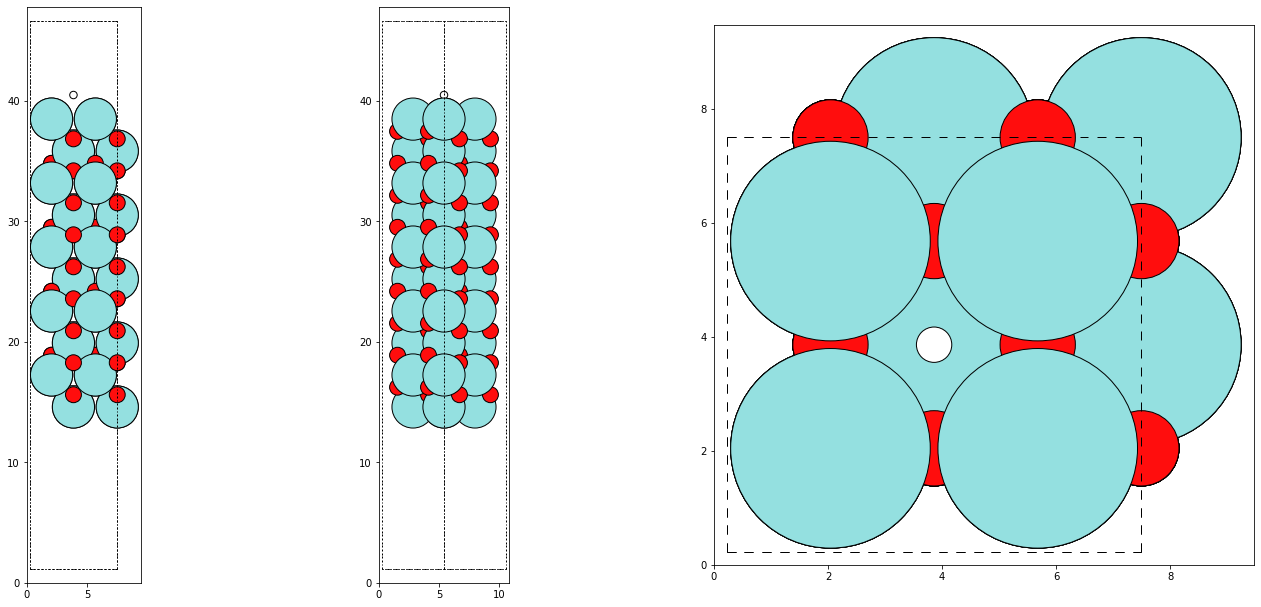

In [16]:
for i, theslab in enumerate(ZrO2001Zrterm_2x2):
    adposition = theslab.info['adatom']['top']['hollow']
    adatom = Atoms('H',positions=[adposition+[0,0,2]])
    adstruc = theslab.copy()
    adstruc.extend(adatom)
    #adstruc.write(f'ZrO20001_ad{site}_{i}.vasp',format='vasp', sort=True, wrap=True)
plotviews(adstruc)

(<Axes:>, <Axes:>, <Axes:>)

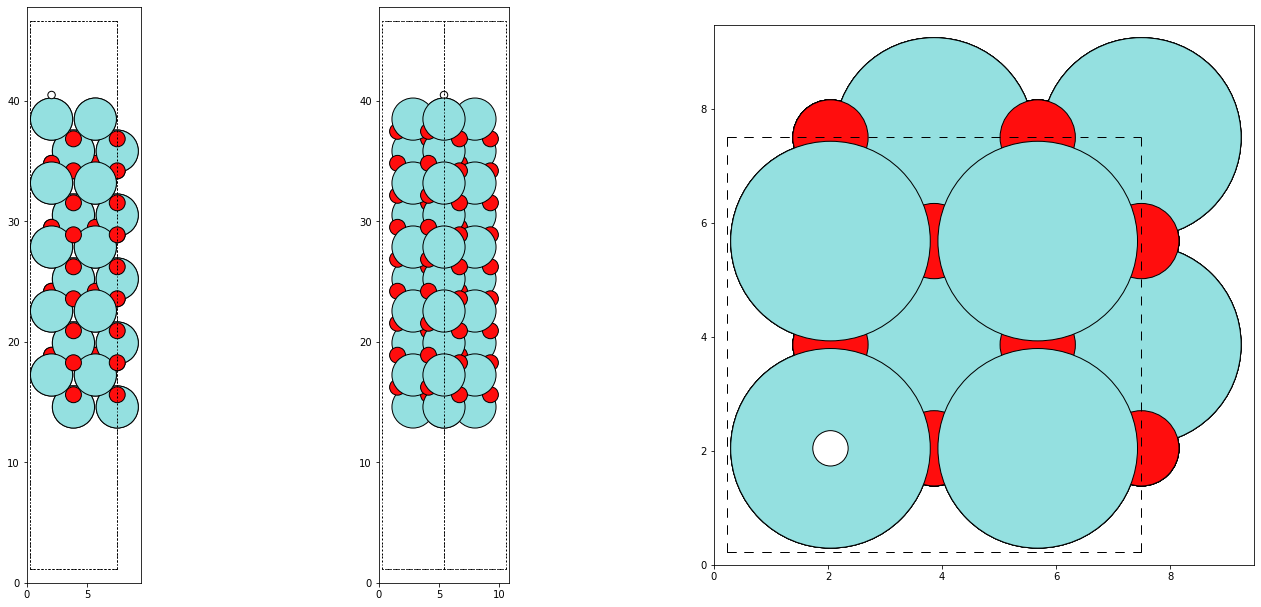

In [17]:
for i, theslab in enumerate(ZrO2001Zrterm_2x2):
    adposition = theslab.info['adatom']['top']['top']
    adatom = Atoms('H',positions=[adposition+[0,0,2]])
    adstruc = theslab.copy()
    adstruc.extend(adatom)
    #adstruc.write(f'ZrO20001_ad{site}_{i}.vasp',format='vasp', sort=True, wrap=True)
plotviews(adstruc)

## circonium

In [18]:
zrhcpa = 3.2313 # Zr.cell[0][0]
zrhcpc = 5.1479 # Zr.cell[-1][-1]

zrhcp = bulk('Zr',crystalstructure='hcp',a=zrhcpa, c = zrhcpc,orthorhombic=False)
zrhcp.write('ZrHCP.vasp', direct=True, wrap=True, sort=True)

(<Axes:>, <Axes:>, <Axes:>)

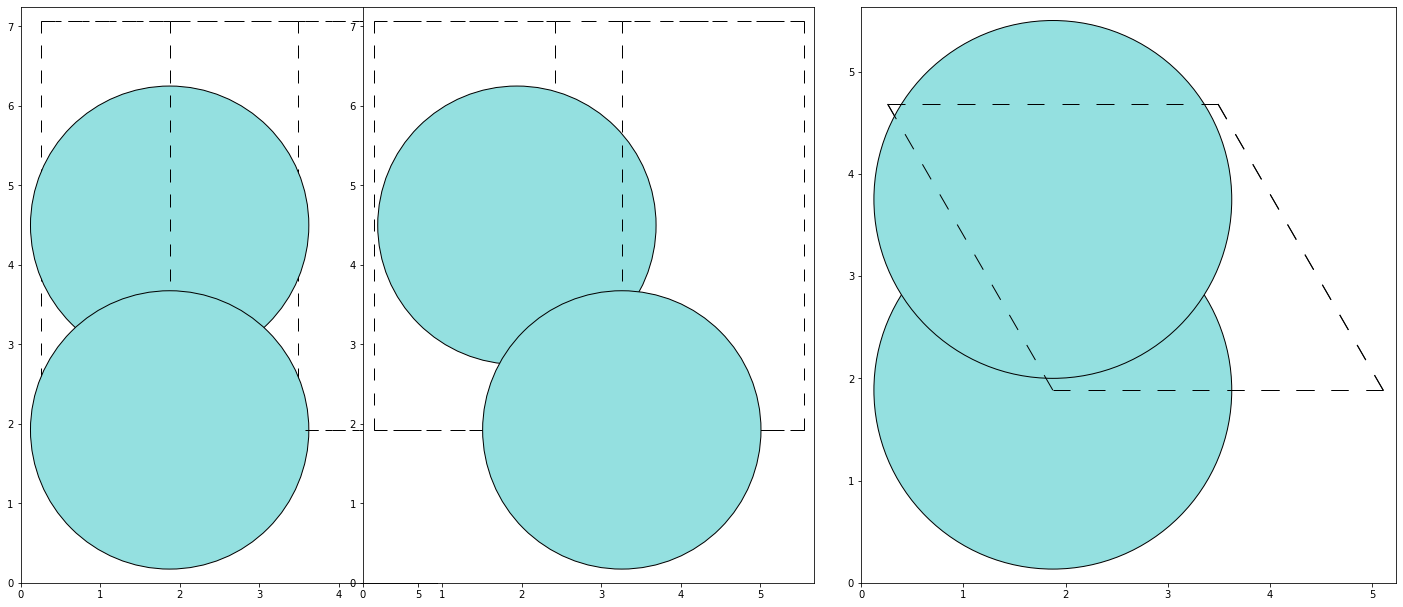

In [19]:
plotviews(zrhcp)

In [20]:
zrhcpa = 3.2313 # Zr.cell[0][0]
zrhcpc = 5.1479 # Zr.cell[-1][-1]

zrhcp = bulk('Zr',crystalstructure='hcp',a=zrhcpa, c = zrhcpc,orthorhombic=True)
zrhcp.write('ZrHCP_ortho.vasp', direct=True, sort=True, wrap=True)

(<Axes:>, <Axes:>, <Axes:>)

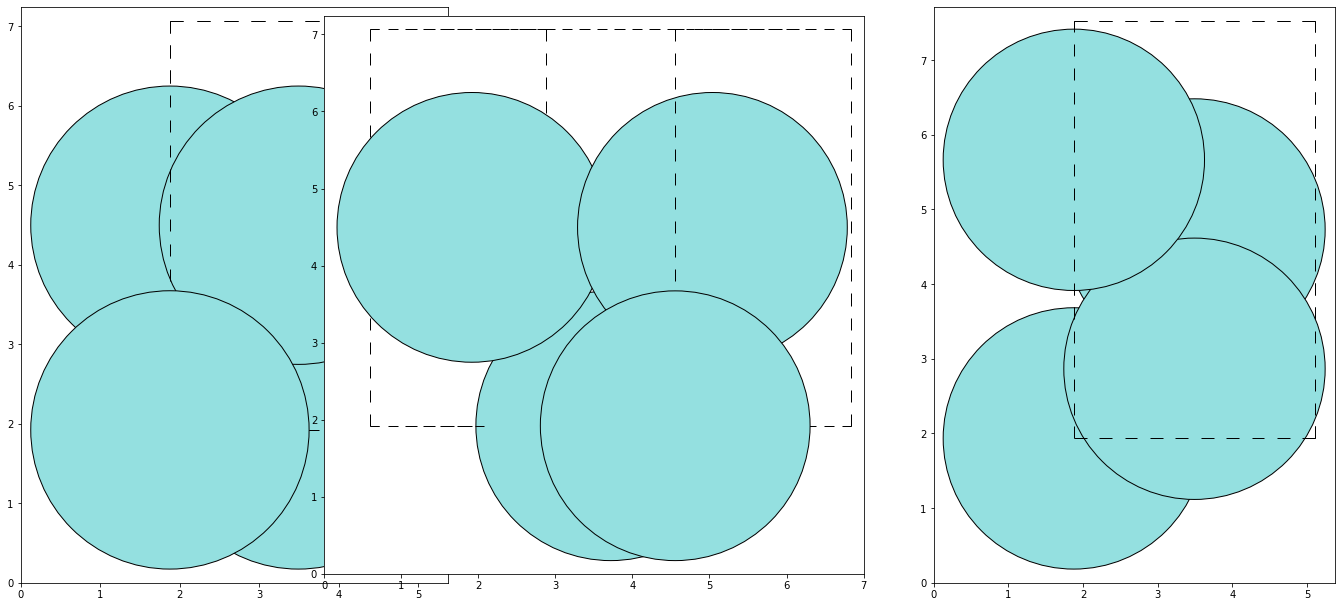

In [21]:
plotviews(zrhcp)

for hexagonal lattices, the equivalence to make the correct surfaces with the orthonormal basis is :
- (0 0 0 1): (0 0 1)
- (1 0 -1 0): (0 1 0)
- (1 1 -2 0): (1 0 0)

now i want to remove the bottom layer, so bottoma nd top have same symmetry

## Zr0001

In [22]:
Zr11m20 = surfaces_with_termination(zrhcp, (1,0,0), 5, vacuum=10, termination='Zr')[0]
Zr11m20 = remove_bottom_atom(Zr11m20)
Zr11m20 = remove_bottom_atom(Zr11m20)
#Zr0001.pop(atoms_in_bottom[-1])

In [23]:
get_adsite = SourceFileLoader(
    'get_adsite',
    'Tools.py').load_module().get_adsite
make_adstruc = SourceFileLoader(
    'make_adstruc',
    'Tools.py').load_module().make_adstruc

In [24]:
adsites_zr11m20 = get_adsite(Zr11m20, face='bottom')

In [25]:
Zr11m20.info

{'adatom': {'bottom': {'hollow': array([ 1.86559192,  1.286975  , 11.61565   ]),
   'top': array([ 2.79838789,  0.        , 11.61565   ]),
   'bridge': array([ 1.86559192,  1.286975  , 11.61565   ])}}}

In [26]:
Zr11m20_adtop = make_adstruc(Zr11m20,'Zr0001_adtop',theface='bottom',)

(<Axes:>, <Axes:>, <Axes:>)

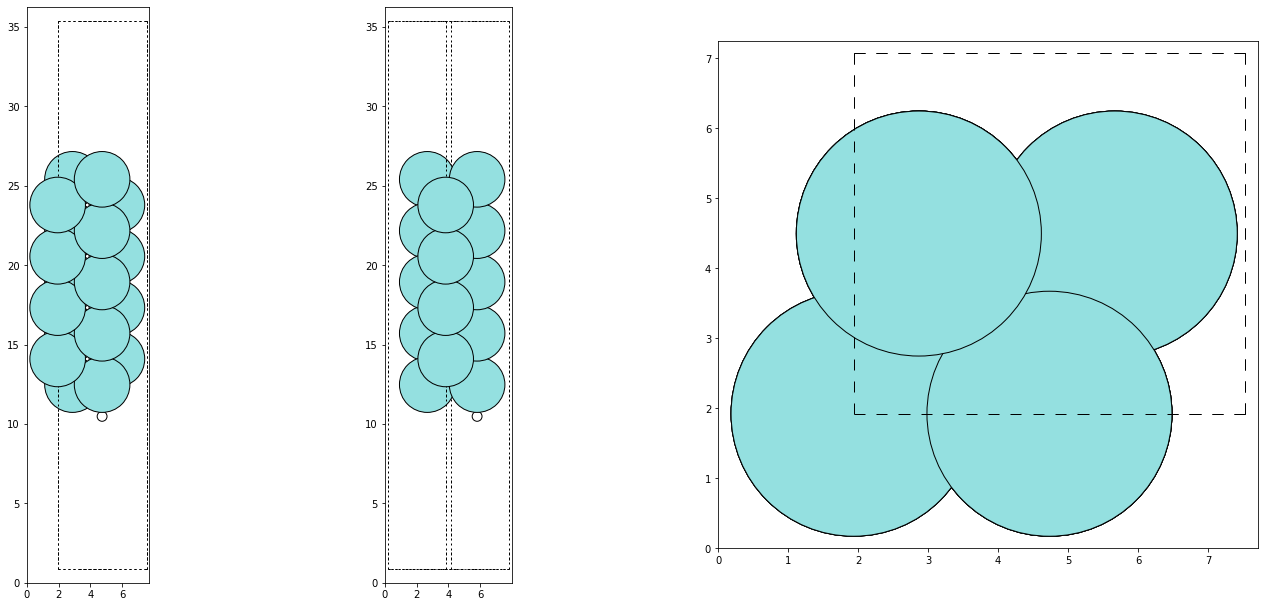

In [27]:
plotviews(Zr11m20_adtop)

Zr0001_2x2=make_supercell(Zr0001, [[2,0,0],[0,1,0],[0,0,1]],)
adsites = get_adsite(Zr0001_2x2,site='top',face='bottom')
Zr0001_2x2.write('Zr0001_2x2.vasp',sort=True,wrap=True, direct=True,vasp5=True)

plotviews(Zr0001_2x2)

adsites_zr0001 = get_adsite(Zr0001, site='top',face='bottom')
adsites_zr0001 = get_adsite(Zr0001, site='hollow', face='bottom')
Zr0001_ontop = make_adstruc(Zr0001,'Zr0001_top',thesite='top',theface='bottom')
Zr0001_onhollow = make_adstruc(Zr0001,'Zr0001_hollow',thesite='hollow',theface='bottom' )

plotviews(Zr0001_onhollow)

## 10-10

In [28]:
Zr0101=surfaces_with_termination(zrhcp,(0,1,0),8, vacuum=10)[0]
Zr0101 = remove_bottom_atom(Zr0101)
Zr0101 = remove_bottom_atom(Zr0101)
Zr0101 = remove_bottom_atom(Zr0101)
Zr0101_1x1 = make_supercell(Zr0101, [[1,0,0],[0,1,0],[0,0,1]], wrap=True)
Zr0101_1x1.write('Zr0001_1x1.vasp', direct=True, wrap=True, sort=True)

In [29]:
adsites_Zr0101 = get_adsite(Zr0101_1x1, site='top',face='bottom')
adsites_Zr0101 = get_adsite(Zr0101_1x1, site='hollow',face='bottom')

In [30]:
Zr0101_ontop = make_adstruc(Zr0101_1x1, 'Zr0101_top',thesite='top',theface='bottom')
Zr0101_onhollow = make_adstruc(
    Zr0101_1x1,
    'Zr0101_hollow',
    thesite='hollow',theface='bottom')

(<Axes:>, <Axes:>, <Axes:>)

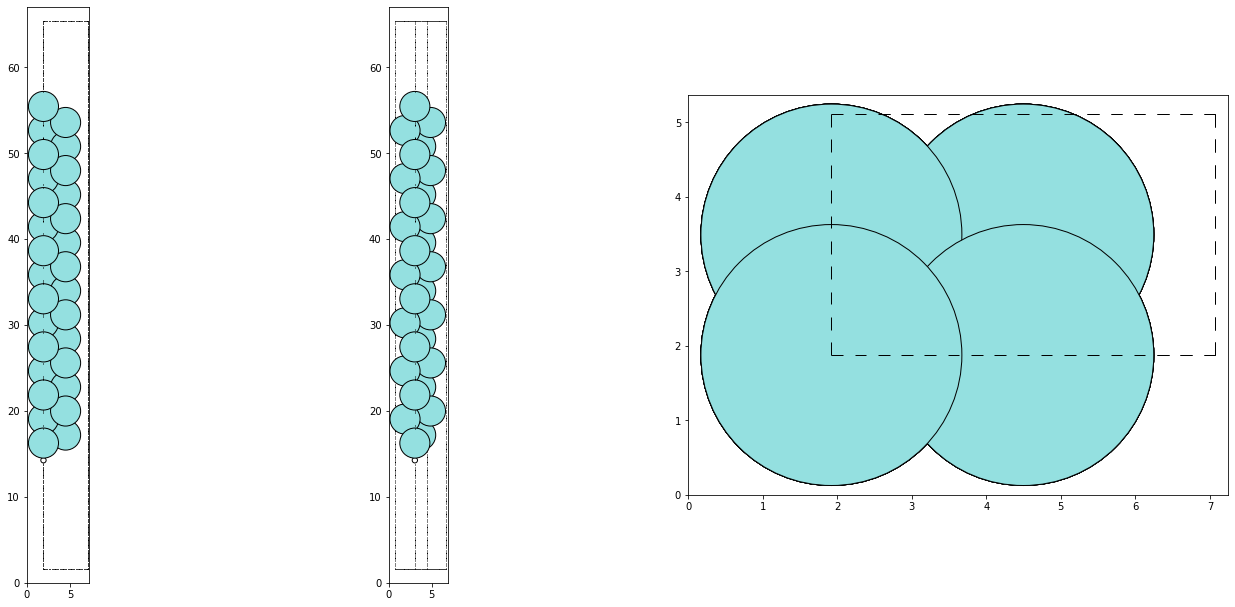

In [31]:
plotviews(Zr0101_ontop)

## zr1120

In [32]:
Zr1120 = surfaces_with_termination(zrhcp,[1,0,0], 10, vacuum=10, symmetric=True)[0]
# Zr1120 = remove_bottom_atom(Zr1120)
# Zr1120 = remove_bottom_atom(Zr1120)


([0, 3], ['Zr', 'Zr']) ([37, 38], ['Zr', 'Zr'])
([1, 2], ['Zr', 'Zr']) ([36, 39], ['Zr', 'Zr'])


In [33]:
adsites_Zr1120 = get_adsite(Zr1120, site='top',face='bottom')
adsites_Zr1120 = get_adsite(Zr1120, site='hollow',face='bottom')

In [34]:
Zr1120.write('Zr1120.vasp',format='vasp',sort=True, direct=True,wrap=True)

In [35]:
Zr1120_ontop = make_adstruc(Zr1120,'Zr1120_top',thesite='top',theface='bottom')
Zr1120_onhollow = make_adstruc(Zr1120,'Zr1120_hollow',thesite='hollow',theface='bottom')

(<Axes:>, <Axes:>, <Axes:>)

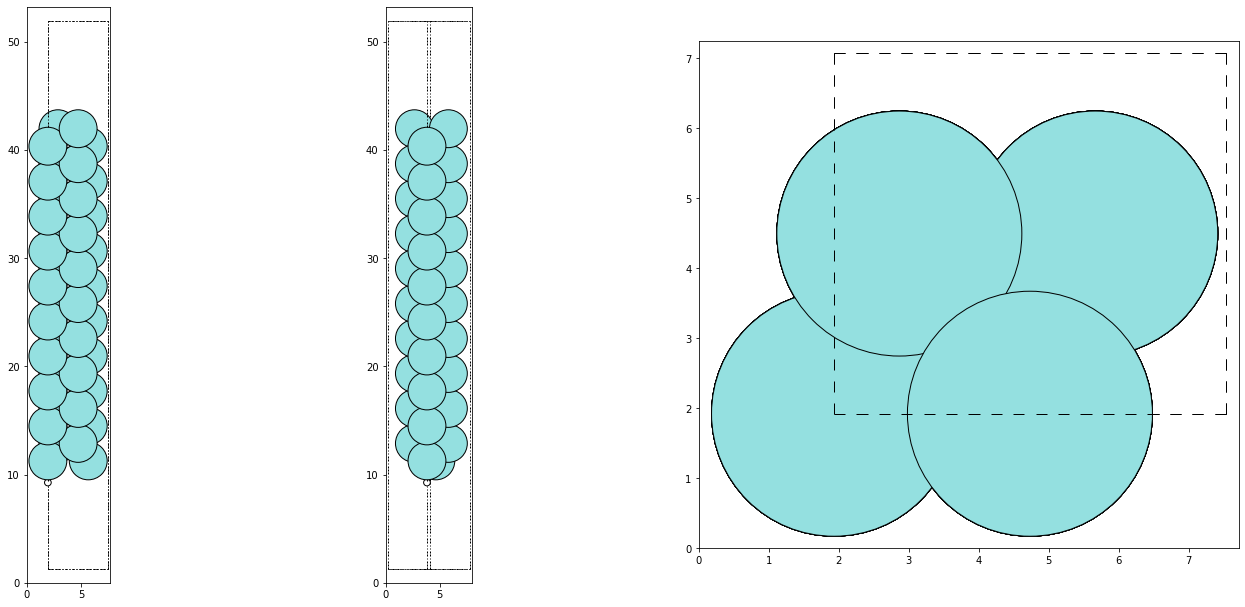

In [36]:
plotviews(Zr1120_ontop)

# Interfaces

In [37]:
distance=4

In [38]:
#atoms1 = ZrO2001_2x2[0].copy()
#atoms1.center()
#correction = (atoms1.positions - ZrO2001_2x2[0].positions).mean(axis=0)
#atoms1.info['adatom']['top']['top']+=correction
#atoms1.info['adatom']['top']['hollow']+=correction
#
#atoms2 = Zr0001_2x2.copy()
#atoms2.cell /= np.linalg.norm(atoms2.cell)
#
#R = atoms1.info['adatom']['top']['top'] - atoms2.info['adatom']['bottom']['top']+[0,0,distance]
#atoms2.translate(R)
#
#stack = atoms1.copy()
#stack.cell /= np.linalg.norm(stack.cell)
#
#stack.extend(atoms2)
#
#height1 = (atoms1.positions.max(axis=0)-atoms1.positions.min(axis=0))[-1]
#height2 = (atoms2.positions.max(axis=0)- atoms2.positions.min(axis=0))[-1]
#
#newcell = ZrO2001_2x2[1].cell.copy()
#
#newcell[2]=[0,0,height1+height2+2*distance]
#
#stack.set_cell(newcell)

#stack.write('stack_test.vasp',format='vasp',wrap=True,direct=True,sort=True)

Ok here is a tricky one. if you dont use a non linked cell in the `cell` option, this option is actually a pointer to the input var. this means that if you use atoms.cell and atoms is a slab to stack, this will totally mess the input atom and the output too. This also happens you you use no cell as imput because it assigns a pointer internally

In [39]:
stack = SourceFileLoader(
    'stack',
    'Tools.py',
    ).load_module().stack

In [40]:
name = 'ZrO2001_Oterm_Zr1120_ontop'

In [41]:
test,part1, part2 = stack(
    ZrO2001Zrterm_2x2[1], 
    Zr11m20, 'top','top',
    5.0,
    cell = ZrO2001Zrterm[1].cell.copy(),
    return_parts=True
            )

(<Axes:>, <Axes:>, <Axes:>)

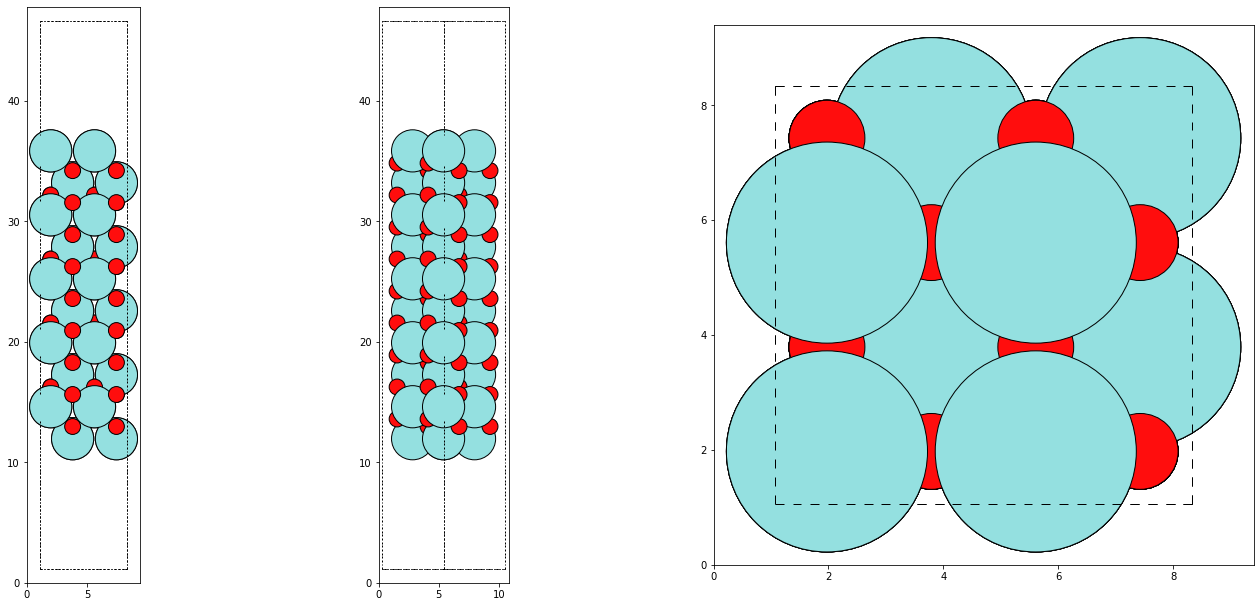

In [42]:
plotviews(part1)

(<Axes:>, <Axes:>, <Axes:>)

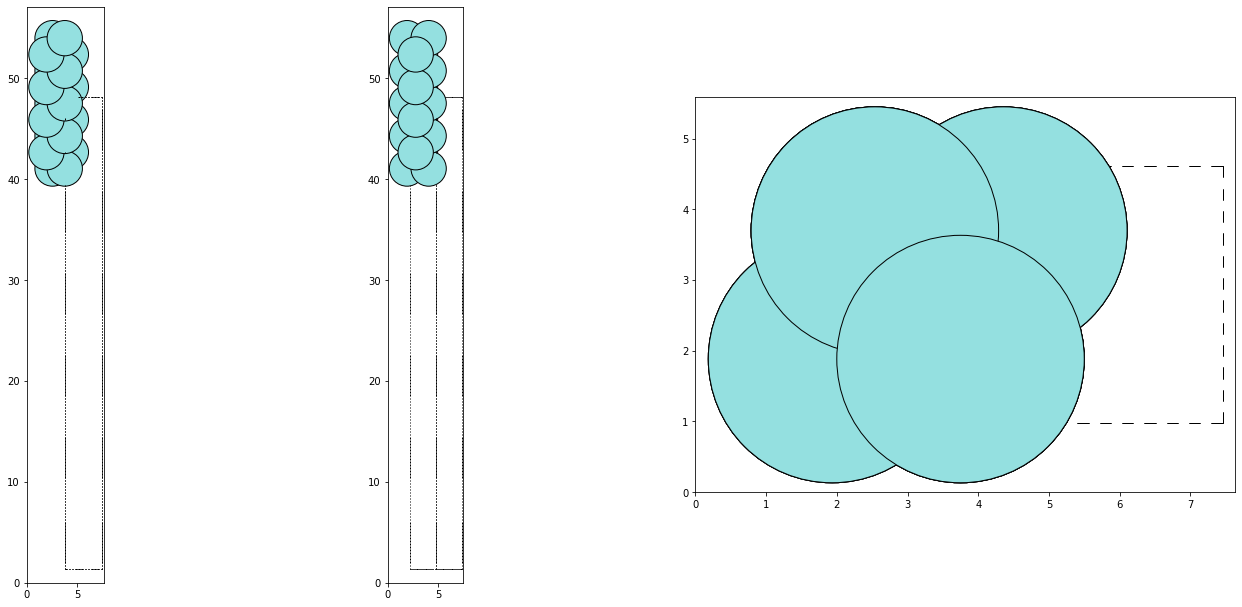

In [43]:
plotviews(part2)

(<Axes:>, <Axes:>, <Axes:>)

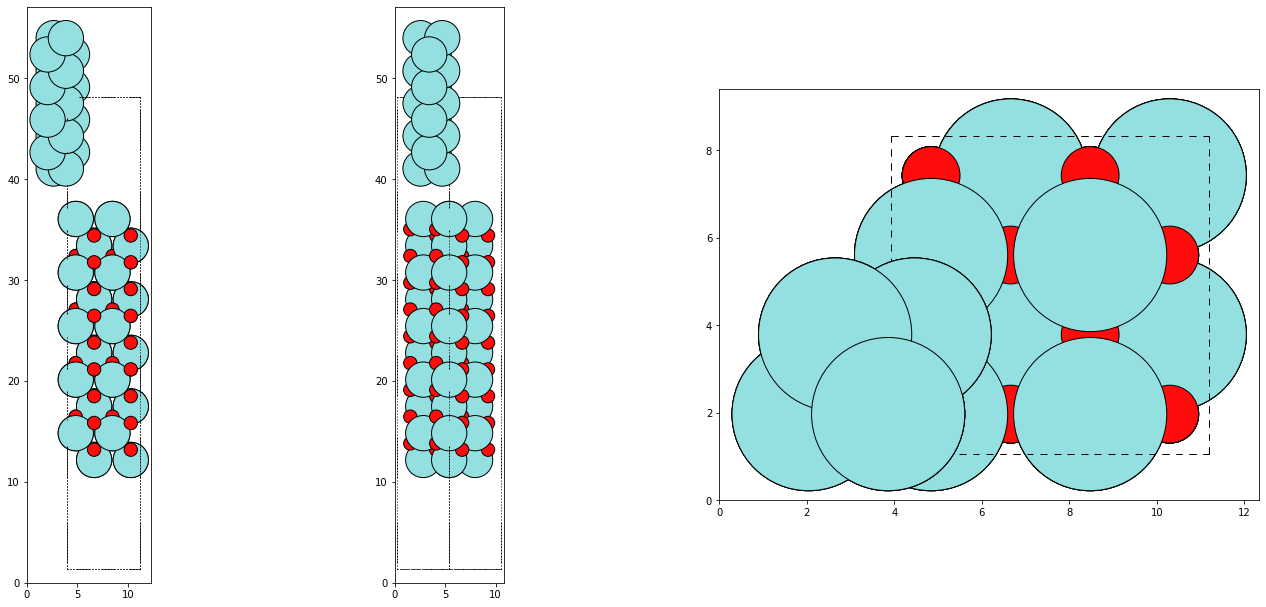

In [44]:
plotviews(test)

In [45]:
test.write('stack_test.vasp',format='vasp',wrap=True,direct=True,sort=True)

(<Axes:>, <Axes:>, <Axes:>)

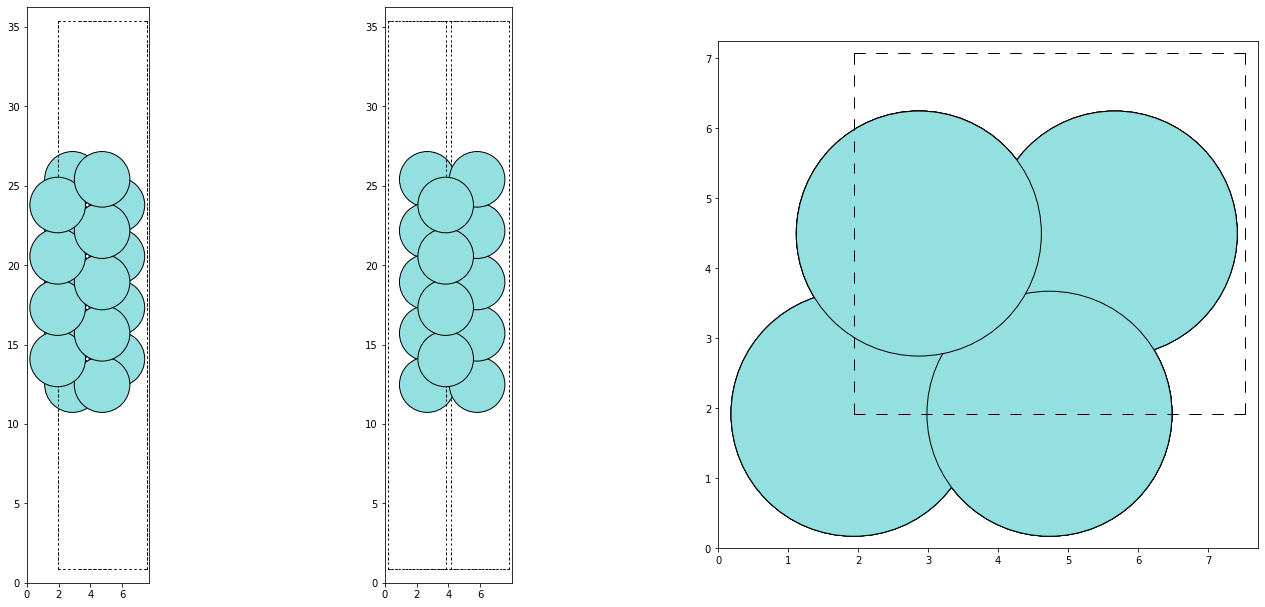

In [83]:
plotviews(Zr11m20)

In [76]:
view(test)

<Popen: returncode: None args: ['/data/Anaconda/ifermi_pymatgen/bin/python',...>

In [331]:
Interface[name] ={i:{
    'structure': stack(ZrO2001_2x2[1], Zr1120, 'top','top',d, cell = ZrO2001_2x2[1].cell.copy()),
    'd': d } for i, d in enumerate([2.0,2.5,3.0,3.5,4.0,6.0])
}

In [266]:
Interface

{'ZrO2001_Oterm_Zr1120_ontop': {0: {'structure': Atoms(symbols='O64Zr66', pbc=True, cell=[7.268397980708341, 7.268397980708341, 50.46423599482303]),
   'd': 2.0},
  1: {'structure': Atoms(symbols='O64Zr66', pbc=True, cell=[7.268397980708341, 7.268397980708341, 51.46423599482303]),
   'd': 2.5},
  2: {'structure': Atoms(symbols='O64Zr66', pbc=True, cell=[7.268397980708341, 7.268397980708341, 52.46423599482303]),
   'd': 3.0},
  3: {'structure': Atoms(symbols='O64Zr66', pbc=True, cell=[7.268397980708341, 7.268397980708341, 53.46423599482303]),
   'd': 3.5},
  4: {'structure': Atoms(symbols='O64Zr66', pbc=True, cell=[7.268397980708341, 7.268397980708341, 54.46423599482303]),
   'd': 4.0},
  5: {'structure': Atoms(symbols='O64Zr66', pbc=True, cell=[7.268397980708341, 7.268397980708341, 58.46423599482303]),
   'd': 6.0}}}

In [267]:
Intf_Loc = 'Interfaces/ZrO2_Oterm_Zr1120_ontop'

In [275]:
for i, thisintf in Interface[name].items():
    print(i, thisintf)
    d='d'
    thisfile = os.path.join(Intf_Loc,f'{name}_d={thisintf[d]}.vasp')
    write_vasp(thisfile, thisintf['structure'], sort=True, wrap=True, direct=True)

0 {'structure': Atoms(symbols='O64Zr66', pbc=True, cell=[7.268397980708341, 7.268397980708341, 50.46423599482303]), 'd': 2.0}
1 {'structure': Atoms(symbols='O64Zr66', pbc=True, cell=[7.268397980708341, 7.268397980708341, 51.46423599482303]), 'd': 2.5}
2 {'structure': Atoms(symbols='O64Zr66', pbc=True, cell=[7.268397980708341, 7.268397980708341, 52.46423599482303]), 'd': 3.0}
3 {'structure': Atoms(symbols='O64Zr66', pbc=True, cell=[7.268397980708341, 7.268397980708341, 53.46423599482303]), 'd': 3.5}
4 {'structure': Atoms(symbols='O64Zr66', pbc=True, cell=[7.268397980708341, 7.268397980708341, 54.46423599482303]), 'd': 4.0}
5 {'structure': Atoms(symbols='O64Zr66', pbc=True, cell=[7.268397980708341, 7.268397980708341, 58.46423599482303]), 'd': 6.0}


In [195]:
thestack.write('Test_ZrO2001_Zr1120.vasp', format = 'vasp', sort=True, wrap=True, direct=True)

In [196]:
view(thestack)

<Popen: returncode: None args: ['/data/Anaconda/ifermi_pymatgen/bin/python',...>

In [169]:
ZrO2001_2x2[1].cell

Cell([7.268397980708341, 7.268397980708341, 50.61383599482303])

In [36]:
Zr0101.__dict__['info']

{}

In [169]:
intfLayer = [stack(Zr0101_2x2.copy(), I.copy(), cell=I.cell.copy(), axis=2, distance=2, maxstrain=4, reorder=True) for I in ZrO2001_2x2]
saveintfs = [a.write( f'intf_zr0101_zro2_{i}.vasp', format='vasp',sort=True,  direct=True,  wrap=True) for i, a in enumerate(intfLayer)]

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 243
         Function evaluations: 398
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 237
         Function evaluations: 392
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 244
         Function evaluations: 393
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 251
         Function evaluations: 405


[(<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>)]

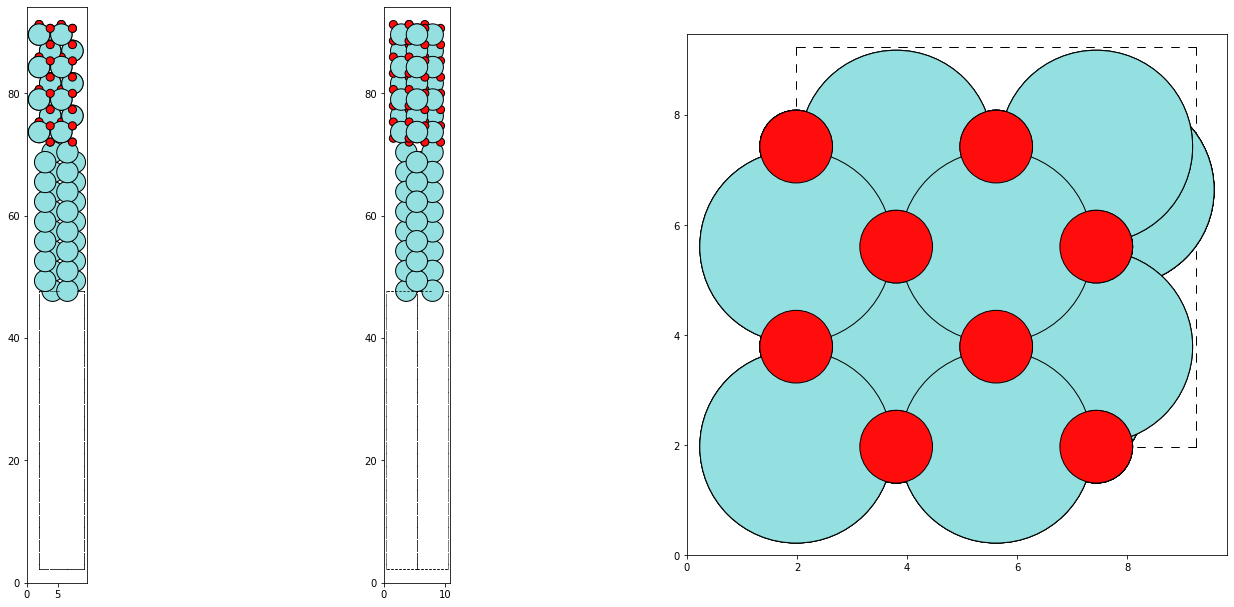

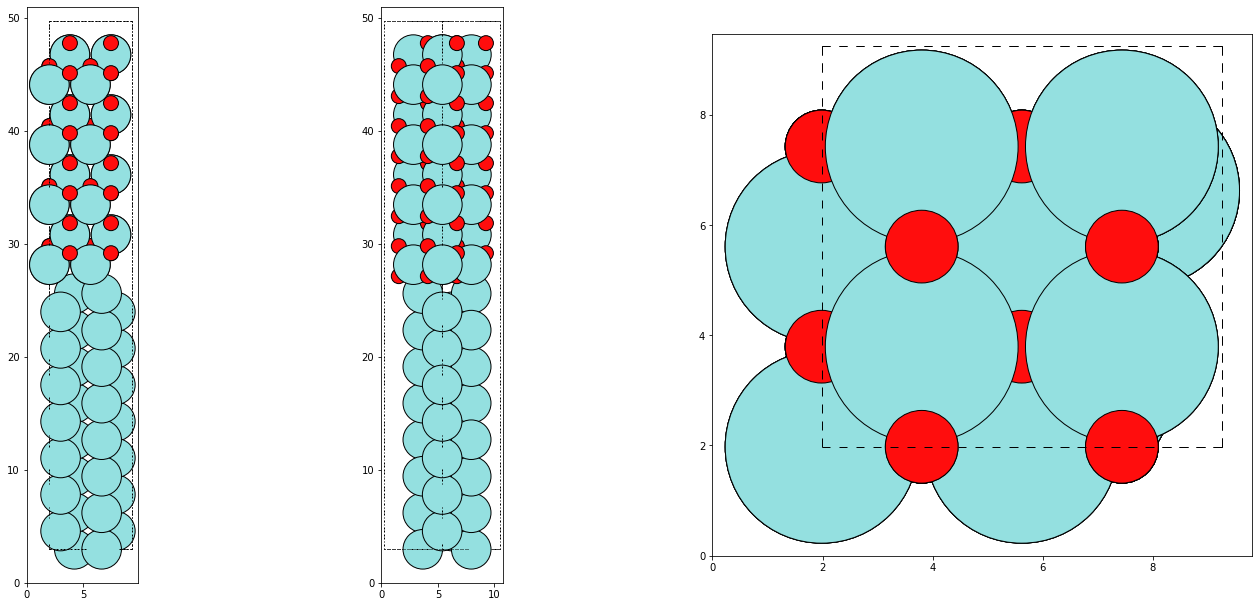

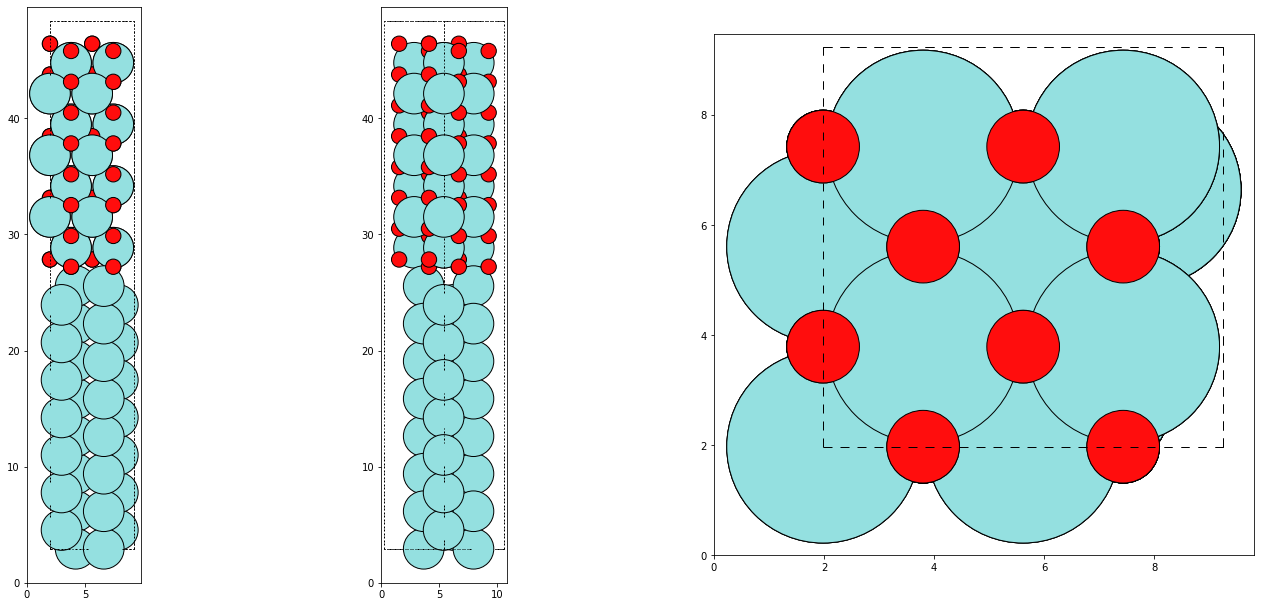

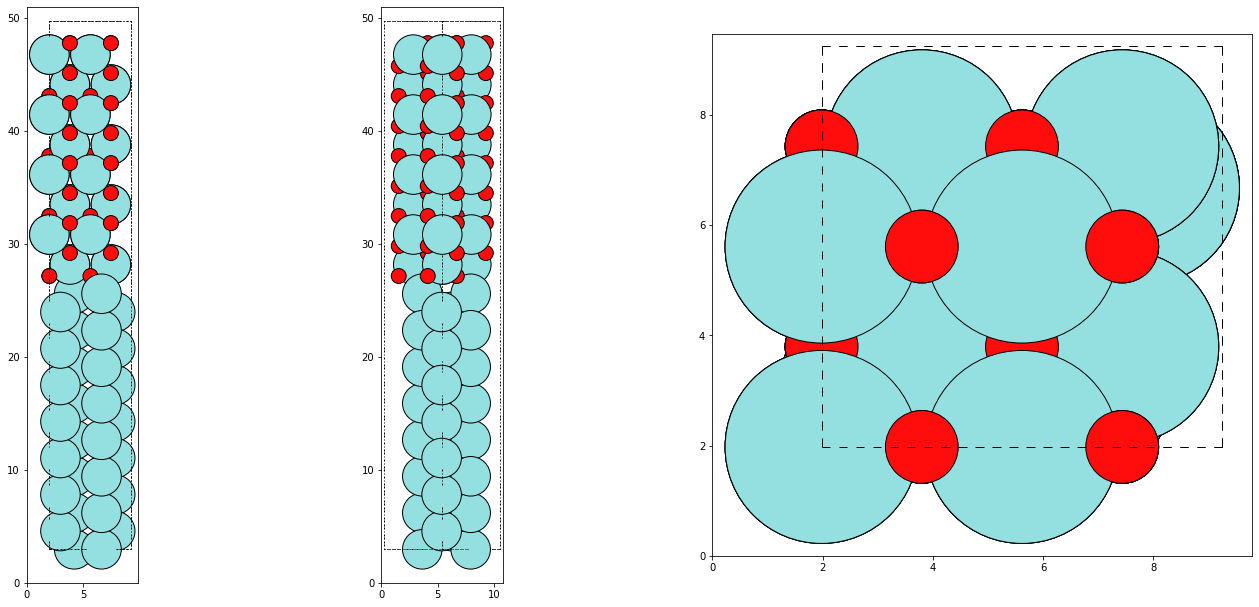

In [170]:
[plotviews(intf) for intf in intfLayer]

In [142]:
intfLayer1120 = [stack(Zr1120.copy(), I.copy(), cell=I.cell.copy(), axis=2, distance=3, maxstrain=4, reorder=True) for I in ZrO2001_2x2]
saveintfs = [a.write( f'intf_zr1120_zro2_{i}.vasp', format='vasp',sort=True,  direct=True,  wrap=True) for i, a in enumerate(intfLayer1120)]

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 273
         Function evaluations: 435
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 291
         Function evaluations: 467
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 276
         Function evaluations: 448
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 301
         Function evaluations: 475


[(<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>),
 (<Axes:>, <Axes:>, <Axes:>)]

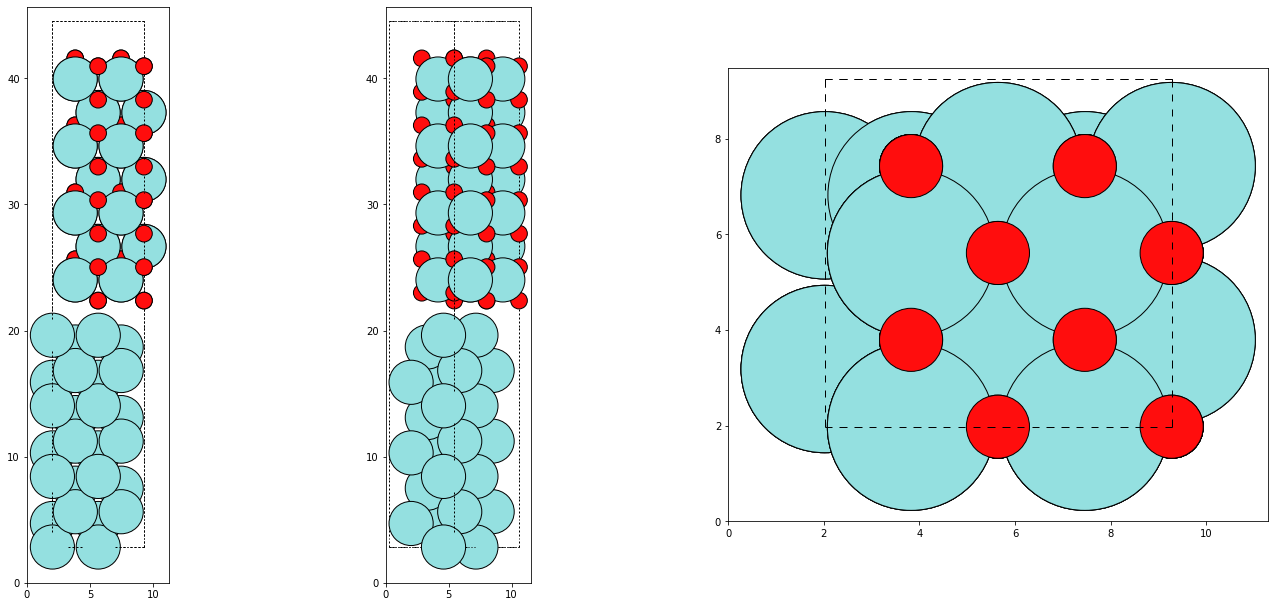

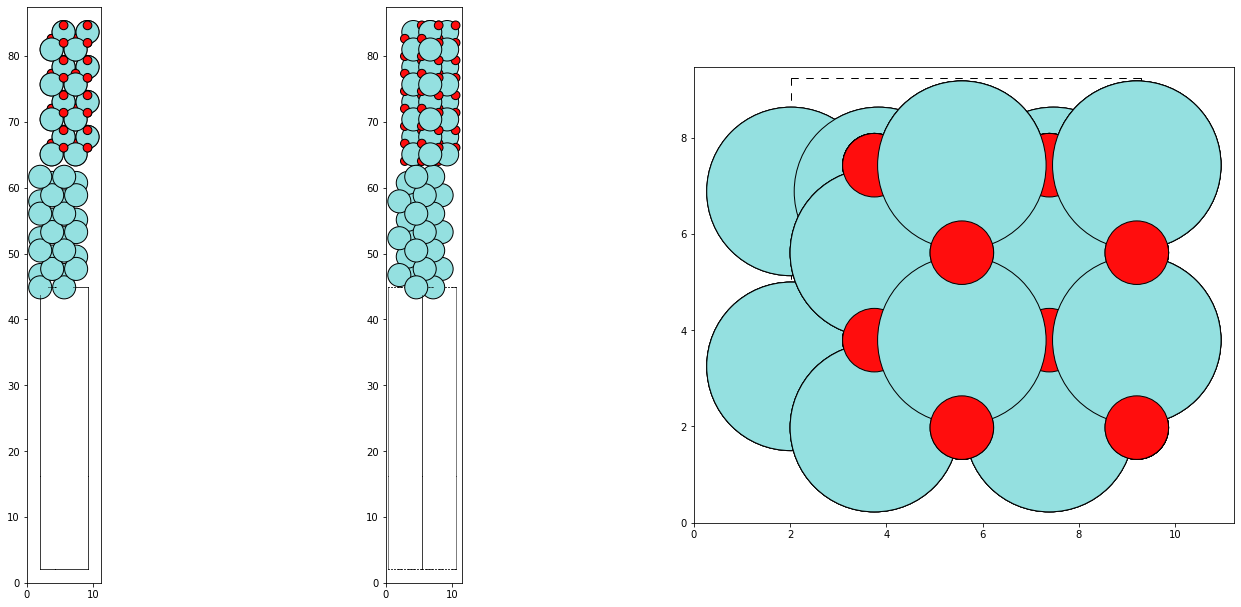

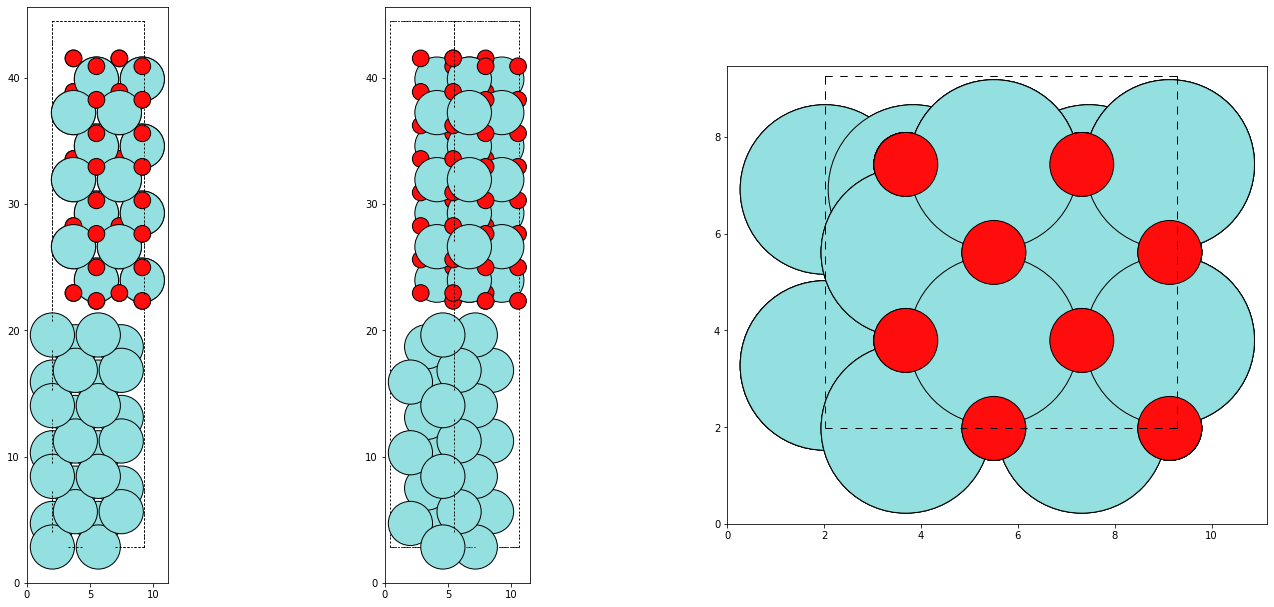

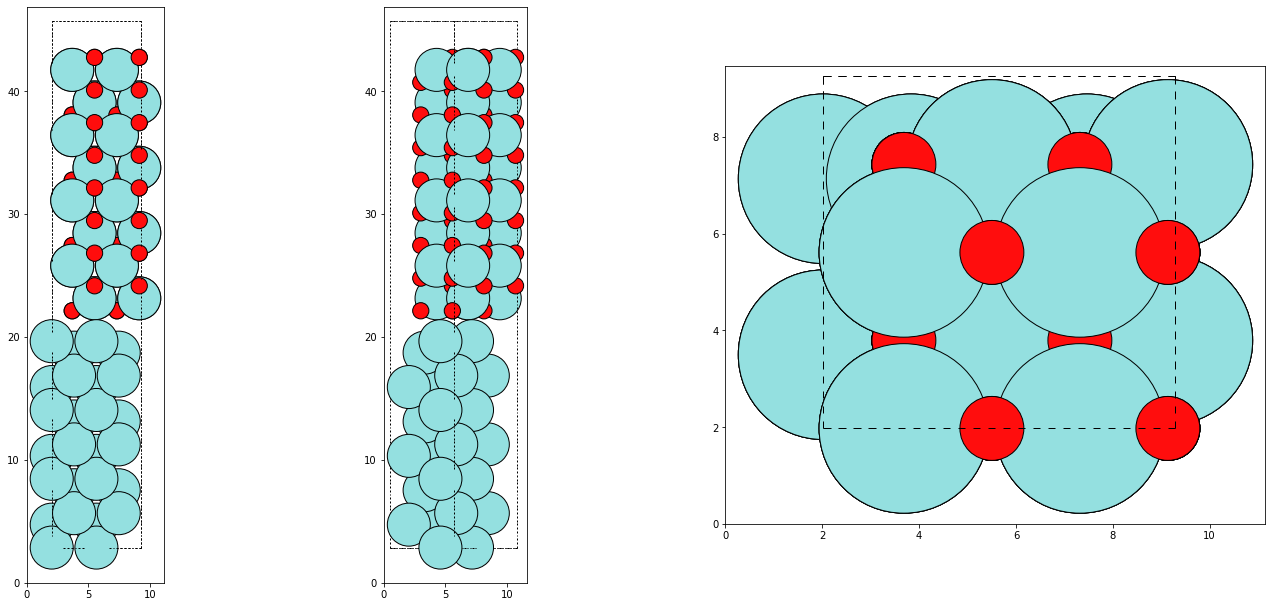

In [143]:
[plotviews(intf) for intf in intfLayer1120]

In [29]:
ZrO2001Oterm[0]

Atoms(symbols='O4ZrO4Zr2O4Zr2O4Zr2', pbc=[True, True, False], cell=[3.6341989903541707, 3.6341989903541707, 50.22092905883963])

In [ ]:
write('Interfaces/Layer_ZrO2.vasp', LayerZrO2)

In [ ]:
write('Interfaces/Layer_Zr1010.vasp', LayerZr1010)

Treated in vesta, can see a small probable coincidence at 2x4:
![coincidence]('Interfaces/Layer_Zr1010_coincidence.tiff')

In [ ]:
Interface = stack(Zr1010, oterm_zro2111x2,maxstrain=2, distance=2 )

In [ ]:
ax1, ax2,ax3 = plotviews(Interface)

In [ ]:
Interface.get_global_number_of_atoms()

In [ ]:
1/np.sqrt(26)

In [ ]:
5/np.sqrt(26)

# Stack

In [ ]:
STACKED = stack(oterm_zro2111x2, ZrHCP1010,maxstrain=1.0, distance=5.0)

In [ ]:
view(STACKED)

In [ ]:
STACKED.__dict__.keys()

In [ ]:
STACKED.__dict__['_cellobj']

In [ ]:
STACKED.cell

In [ ]:
ZrO2_super.cell

In [ ]:
ZrHCP1010.cell

In [ ]:
STACKED.get_global_number_of_atoms()

In [ ]:
view(ZrHCP1010)

In [ ]:
Zr.cell